<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study: Complexity Theory**

This is a worksheet prepared by Evan Peters for Lecture 4 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: [Quantum Computing, An Applied Approach](https://www.springer.com/gp/book/9783030239213) by Jack D. Hidary (2019)

In [ ]:
!pip install cirq

     |████████████████████████████████| 1.2MB 8.5MB/s 
     |████████████████████████████████| 1.8MB 34.0MB/s 
     |████████████████████████████████| 1.2MB 43.9MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=aac856673e34b17fd2c75dd8307552d2825c42a17a7a7e8338a79eedbb39a303
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


## Case Study: Classical complexity of quantum circuit simulators

QIP tends to focus on the _algorithmic_ complexity when comparing quantum circuits to some classical counterpart problem. However here I'll introduce a quick study into the complexity of running a classical simulation of a quantum algorithm. The goal is to provide a means of estimating the scaling and overheads that a user might experience as they try to run quantum circuit simulations.

---

Small survey: 
* Whats the time complexity of simulating a Clifford circuit using...
    * ...stabilizer formalism
    * ...unitary matrix multiplication

* Whats the total time complexity doing something with complexity $\mathcal{O}(m)$ followed by something else with complexity $\mathcal{O}(m^2)$ ?

---

### Computing matrix products

Given: Two matrices, $A$ and $B$ with shapes like $(m \times n) and (n \times \ell)$ respectively

Find: Complexity of matrix multiplication $AB$

_Use the algorithm below. How does the total number of multiplications scale with each of m, n, l?_

In [ ]:
# Algorithm for matrix multiplication
import numpy as np
m, n, el = 10, 20, 13
A = np.random.random(size=(m, n))
B = np.random.random(size=(n, el))
C = np.zeros((m, el))
for i in range(m):
  for j in range(el):
    for k in range(n):
      C[i,j] += A[i,k] * B[k,j]


### Computing amplitudes in a quantum state

Given: Array multiplication of shapes like $(m \times n) * (n \times \ell)$ has complexity $\mathcal{O}(mn\ell)$

Goal: Compute $U_k U_j |\psi \rangle$ with lowest possible complexity.

 - Each $U_s \in \mathbb{C}^{2^s \times 2^s}$  acts on $s$ qubits, $s = k, j$

- $|\psi \rangle \in \mathbb{C}^{2^m}$ acts over $m$ qubits

---
#### 1. Naive algorithm

"Naive" square matrix multiplication scales like $\mathcal{O}(n^3)$. This results in $\mathcal{O}(2^{3m})$ complexity:

1. While $j < m$, tensor up $U_j$ with identity matrices (This is $\mathcal{O}(2^{2m})$ since we have to fill a $(2^m \times 2^m)$ sparse matrix with values)
2. Repeat for $U_k$ while $k < m$
3. Matrix multiplication $U_j U_k$  (This is $\mathcal{O}(2^{3m})$ using our formula for matrix multiplication complexity from above)
4. Multiply the result by $\psi$ (This is $\mathcal{O}(2^{2m})$ using our above formula for shapes $(2^m \times 2^m) * (2^m \times 1)$)

<u>Total Complexity</u>: $\mathcal{O}(2^{3m})$

---
#### 2. Quick and easy improvement
Do the above but swap steps [3] and [4]. That is,
3. Multiply  $ U_k \psi$ ... $\mathcal{O}(2^{2m})$
4. Multiply $ U_j$ by the result... $\mathcal{O}(2^{2m})$

<u>Total Complexity</u>: $\mathcal{O}(2^{2m})$

We just exponentially improved by changing barely anything, since **matmul complexity is not constant with respect to associativity**. That is, the matrix multiplication $ABC$ can have vastly different complexities if its computed as $A(BC)$ compared to $(AB)C$. This comes across a wide range of fields, including autodifferentiation ('backpropagation'), tensor networks (specificially, tensor contraction), and quantum circuit simulators.

Lets look at a quick practical demo of how complexity affects runtime


In [ ]:
# Demo: Timing scaling of matmul
import numpy as np
import cirq
from timeit import default_timer as timer # <-- This is how we'll benchmark
from tqdm import tqdm # <-- This is a cool library for progress bars

matrix_sizes = np.logspace(1, 3.5, 100, dtype=np.int)
times = []
for m in tqdm(matrix_sizes):
  a = np.random.random(size=(m, m))
  b = np.random.random(size=(m, m))
  start = timer()
  np.dot(a, b)
  end = timer()
  times.append(end - start)
  

100%|██████████| 100/100 [00:14<00:00,  1.21it/s]


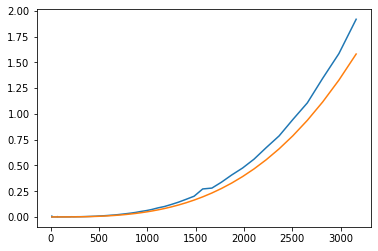

In [ ]:
import matplotlib.pyplot as plt
plt.plot(matrix_sizes, times)
plt.plot(matrix_sizes, matrix_sizes ** 3 / 2e10) # <--- empirical scaling factor

#### 3. Tensor contraction

So far we haven't done any better than $\mathcal{O}(2^{2m})$ calculation of the $2^m$ amplitues in a wavefunction. But we should be able to satisfy a $\mathcal{O}(2^m)$ lower bound in some cases (why?).

To further improve our performance lets introduce tensors. For relevance, discussion is limited to N-dimensional tensors where each dimension is size-2. The tensor is simply a collection of numbers with an index corresponding to every dimension. 

For example, we could define a 2-Tensor:
$$
X_{ij}=\begin{pmatrix}
    x_{00}       & x_{01}  \\
    x_{10}      & x_{11} 
\end{pmatrix}
$$

Because of our size-2 restriction we require $i,j \in [0,1]$. We can also specify a 1-qubit state like this:
$$
\psi_{i}=\begin{pmatrix}
    \psi_{0}        \\
    \psi_{1}     
\end{pmatrix}
$$

If we want to define a 2-qubit state, we add another dimension:
$$
\psi_{ij}=\begin{pmatrix}
    \psi_{00}       & \psi_{01}  \\
    \psi_{10}      & \psi_{11}    
\end{pmatrix}
$$
How do we interpret these amplitudes? Just read off the base-10 value of the binary subscript on each amplitude. Then you can reconstruct a regular 4x1 wavefunction:
$$
\psi_{ij}=\begin{pmatrix}
    \psi_{00}    \\ \psi_{01}  \\
    \psi_{10}      \\ \psi_{11}    
\end{pmatrix}\rightarrow \begin{pmatrix}
    \psi_{0}    \\ \psi_{1}  \\
    \psi_{2}      \\ \psi_{3}    
\end{pmatrix}
$$

For a 3-qubit state, we add yet another dimension:
$$
\psi_{ijk}=\begin{pmatrix}
    \psi_{000}       & \psi_{001}  \\
    \psi_{010}      & \psi_{011}   \\
    \psi_{100}       & \psi_{101}  \\
    \psi_{110}      & \psi_{111}   
\end{pmatrix}
$$

Tensors can be thought of as nested matrices, where indices in the outermost matrix point to inner matrices. In this view, our state looks like this:

![](https://drive.google.com/uc?id=1fiavWcbIFUl6bobxMY7gUSKuWGqzvxQ1)    

So to find $\psi_{010}$ go to the zeroth row of the outermost matrix, then the first row of the next matrix in, then the zeroth column of that row. 




In [ ]:
# Example of using tensors in numpy/cirq
import cirq

# Create an array with integers from 0 to 8:
v = cirq.testing.random_superposition(8)
print(v)
print(v.shape)

[-0.11331812-0.18930691j -0.05960319+0.18412199j -0.01806402+0.50849099j
  0.02335629+0.46844417j -0.00436651+0.06903506j -0.15900937+0.32144014j
 -0.43121931+0.23821223j  0.12214662-0.20972838j]
(8,)


In [ ]:
# To find the amplitude to be in "|010>", index at the location `decimal(0b010)`
index = int(0b010)
v[index]

(-0.018064022115801045+0.5084909922991787j)

In [ ]:
# reshape the array into a 2 x 2 x 2 tensor
v = v.reshape((2,2,2))
print(v)

[[[-0.11331812-0.18930691j -0.05960319+0.18412199j]
  [-0.01806402+0.50849099j  0.02335629+0.46844417j]]

 [[-0.00436651+0.06903506j -0.15900937+0.32144014j]
  [-0.43121931+0.23821223j  0.12214662-0.20972838j]]]


In [ ]:
# Now its easier to access the amplitude for the qubits to be in "|010>"
v[0,1,0]

(-0.018064022115801045+0.5084909922991787j)

Now we're ready to implement more efficient operations. For example, lets compute $ |\phi \rangle = U |\psi \rangle$ for a two-qubit gate acting on a 3-qubit state. A two-qubit gate is represented by a 4x4 matrix, which requires 4 size-2 dimensions to represent as a tensor: $U \rightarrow U_{ijk\ell}$. Meanwhile a 3-qubit state has three indices as we saw above: $\psi \rightarrow \psi_{mnp}$. If the two-qubit matrix acts on qubits 0 and 2, we write the following to represent multiplication occuring only in that subspace:
$$
\phi_{jm\ell} = U_{ijk\ell}\psi_{imk}
$$

We set up $\psi$ and $U$ to share indices in the subspace that we wanted to multiply - at indices 0 and 2, which represent information held in states 0 and 2 - and then we multiplied _only the submatrices defined by those indices_. 

Why bother? The above operation turns out to have complexity $\mathcal{O}(2^{m+2})$, which is an exponential speedup over the previous method. 

**The main takeaway**: Tensor contractions allow us to do amplitude updates in states without the massive overhead of $2^n \times 2^n$ matrix multiplication. "Tensor Networks" are just larger chains of products like the one we computed above, where nodes are defined as tensors and edges are defined as shared indices.

Lets interrogate Cirq and confirm that they are doing multiplication efficiently

In [ ]:
# Benchmark demo 1: Constant operation over larger state
# If I only have a single CNOT in my circuit, how much slowdown do I incur
# by acting on larger and larger states?
# We will time how long it takes to run CNOT|psi> 3000 times, for increasing
# sizes of |psi>
state_sizes = range(2, 8)
times = []
for m in tqdm(state_sizes):
  qubits = cirq.GridQubit.rect(1, m)
  circuit = cirq.Circuit(cirq.CNOT(qubits[0], qubits[-1]))
  circuit += cirq.measure_each(*qubits)
  display(circuit)
  tot_time = 0
  # We run the circuit 3000 times = 3000 sample size
  for _ in range(3000):
    start = timer() 
    cirq.Simulator().simulate(circuit)
    end = timer()
    tot_time += end - start
  times.append(tot_time) # <- you should actually look at _minimum_ times, but colab servers are finnicky...

  0%|          | 0/6 [00:00<?, ?it/s]

(0, 0): ───@───M───
           │
(0, 1): ───X───M───

 17%|█▋        | 1/6 [00:02<00:13,  2.71s/it]

┌──┐
(0, 0): ────@─────M───
            │
(0, 1): ────┼M────────
            │
(0, 2): ────X─────M───
           └──┘

 33%|███▎      | 2/6 [00:06<00:11,  2.95s/it]

┌──┐
(0, 0): ────@─────M───
            │
(0, 1): ────┼M────────
            │
(0, 2): ────┼M────────
            │
(0, 3): ────X─────M───
           └──┘

 50%|█████     | 3/6 [00:10<00:09,  3.33s/it]

┌──┐
(0, 0): ────@─────M───
            │
(0, 1): ────┼M────────
            │
(0, 2): ────┼M────────
            │
(0, 3): ────┼M────────
            │
(0, 4): ────X─────M───
           └──┘

 67%|██████▋   | 4/6 [00:15<00:07,  3.85s/it]

┌──┐
(0, 0): ────@─────M───
            │
(0, 1): ────┼M────────
            │
(0, 2): ────┼M────────
            │
(0, 3): ────┼M────────
            │
(0, 4): ────┼M────────
            │
(0, 5): ────X─────M───
           └──┘

 83%|████████▎ | 5/6 [00:21<00:04,  4.43s/it]

┌──┐
(0, 0): ────@─────M───
            │
(0, 1): ────┼M────────
            │
(0, 2): ────┼M────────
            │
(0, 3): ────┼M────────
            │
(0, 4): ────┼M────────
            │
(0, 5): ────┼M────────
            │
(0, 6): ────X─────M───
           └──┘

100%|██████████| 6/6 [00:27<00:00,  5.10s/it]


Text(0, 0.5, 'Total time')

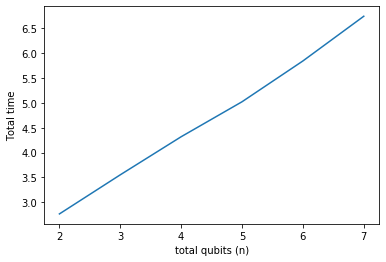

In [ ]:
plt.plot(state_sizes, times)
plt.xlabel("total qubits (n)")
plt.ylabel("Total time")

Time increases linearly, which is _way_ better than exponentially and is actually due to read/write and memory OPS and not algorithmic complexity. 

#### 4. Nonlinear array operations
Meanwhile, we can show empirically that some gates can be computed faster than others:


In [ ]:
# Demo 2: Simulation speed of different gates
# Here we will run a circuit consisting of 5000 of a gate in a row and 
# record the total runtime
qubit = cirq.GridQubit(0, 0)

def benchmark_gate(n, gate):
  """Time n simulation iterations of gate."""
  circuit = cirq.Circuit()
  sim = cirq.Simulator()
  for _ in range(n):
    circuit += gate.on(qubit)

  start = timer() 
  sim.simulate(circuit)
  end = timer()
  return end - start


# Run the experiment for a bunch of gates
n = 5000
display(cirq.Circuit(cirq.X(qubit)))
print(f"\tTime to run {n} times:", benchmark_gate(n, cirq.X), "\n")
display(cirq.Circuit(cirq.Y(qubit)))
print(f"\tTime to run {n} times:", benchmark_gate(n, cirq.Y), "\n")
display(cirq.Circuit(cirq.T.on(qubit)))
print(f"\tTime to run {n} times:", benchmark_gate(n, cirq.T), "\n")
display(cirq.Circuit(cirq.H(qubit)))
print(f"\tTime to run {n} times:", benchmark_gate(n, cirq.H), "\n")
display(cirq.Circuit(cirq.Rx(.3958).on(qubit)))
print(f"\tTime to run {n} times:", benchmark_gate(n, cirq.Rx(.3958)), "\n")


(0, 0): ───X───

	Time to run 5000 times: 0.48989480399995955 



(0, 0): ───Y───

	Time to run 5000 times: 0.5362299620001068 



(0, 0): ───T───

	Time to run 5000 times: 0.498792135000258 



(0, 0): ───H───

	Time to run 5000 times: 0.6473524289999659 



(0, 0): ───Rx(0.126π)───

	Time to run 5000 times: 0.7710820390002482 



Some gates are harder to simulate than others! Here I will just demonstrate with an example why some gates like $X$ are so fast. Suppose we have a three-qubit state $\psi_{ijk}$ and want to apply $X(0)$. With our tensor form of states, we can just shuffle the matrices around, and not do any multiplication at all!

![](https://drive.google.com/uc?id=1bm_8ctIVQt8bo1B_o19lJwXIpfcDAIg5)

Tensor indexing turns out to be $\mathcal{O}(1)$, so our complexity is now as low as $\mathcal{O}(2^{m+1})$.

The generalization of techniques leads to "Tensor Network" simulations of quantum states (a good intro reference is ([Biamonte, 2017](https://arxiv.org/pdf/1708.00006.pdf))) ). Many of the most competitive large quantum state simulators use tensor networks, including [IBM's rebuttal to Google's supremacy paper](https://www.ibm.com/blogs/research/2019/10/on-quantum-supremac|y/).